
# Gradcam example for ImageNet, ResNet50


## References
***
- Darkon Documentation: http://darkon.io
- Darkon Github: https://github.com/darkonhub/darkon
- Resnet code: https://github.com/wenxinxu/resnet-in-tensorflow
- More examples: https://github.com/darkonhub/darkon-examples


## prepare
***
- cpu
pip install -r requirements.txt

- gpu
pip install -r requirements.txt
pip install tensorflow-gpu


## Import packages

In [4]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.contrib.slim.nets import resnet_v1
import tensorflow.contrib.slim as slim
from imagenet_decoder import imagenet_decoder

import darkon

# to enable specific GPU
%set_env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


## build resnet network

In [5]:
#load image
image = cv2.imread('test/data/tooth_brush.png')
image = image.astype(np.float)
image = cv2.resize(image,(224,224))

tf.reset_default_graph()
nclasses = 1000
inputs = tf.placeholder(tf.float32, [1,224,224,3])

#load network resnet50
with slim.arg_scope(resnet_v1.resnet_arg_scope()):
    net, end_points = resnet_v1.resnet_v1_50(inputs, nclasses, is_training=False)

## restore pretrained resnet model

In [6]:
#restore pretrained model
saver = tf.train.Saver(tf.global_variables())
check_point = 'test/data/resnet_v1_50.ckpt'
sess = tf.InteractiveSession()
saver.restore(sess, check_point)

graph = tf.get_default_graph()
print(darkon.Gradcam.candidate_featuremap_op_names(sess, graph)[-5:])

INFO:tensorflow:Restoring parameters from test/data/resnet_v1_50.ckpt
[u'resnet_v1_50/block4/unit_3/bottleneck_v1/conv2/Relu', u'resnet_v1_50/block4/unit_3/bottleneck_v1/conv3/Conv2D', u'resnet_v1_50/block4/unit_3/bottleneck_v1/conv3/BatchNorm/FusedBatchNorm', u'resnet_v1_50/block4/unit_3/bottleneck_v1/add', u'resnet_v1_50/block4/unit_3/bottleneck_v1/Relu']


choose 'resnet_v1_50/block4/unit_3/bottleneck_v1/Relu' as targer layer

In [7]:
conv_name = 'resnet_v1_50/block4/unit_3/bottleneck_v1/Relu'
insp = darkon.Gradcam(inputs, nclasses, conv_name, graph = graph)

In [8]:
probs = insp._prob_ts
probs_eval = sess.run(probs,feed_dict={inputs:np.reshape(image,(1,224,224,3))})
top5_result = imagenet_decoder(probs_eval)
print(top5_result)

[('paintbrush', 696), ('sea urchin', 328), ('vase', 883), ('lighter, light, igniter, ignitor', 626), ('peacock', 84)]


/home/sunghwan/darkon/darkon/gradcam/gradcam.py:144: RuntimeWarning: invalid value encountered in true_divide
  heatmap = cam / np.max(cam)


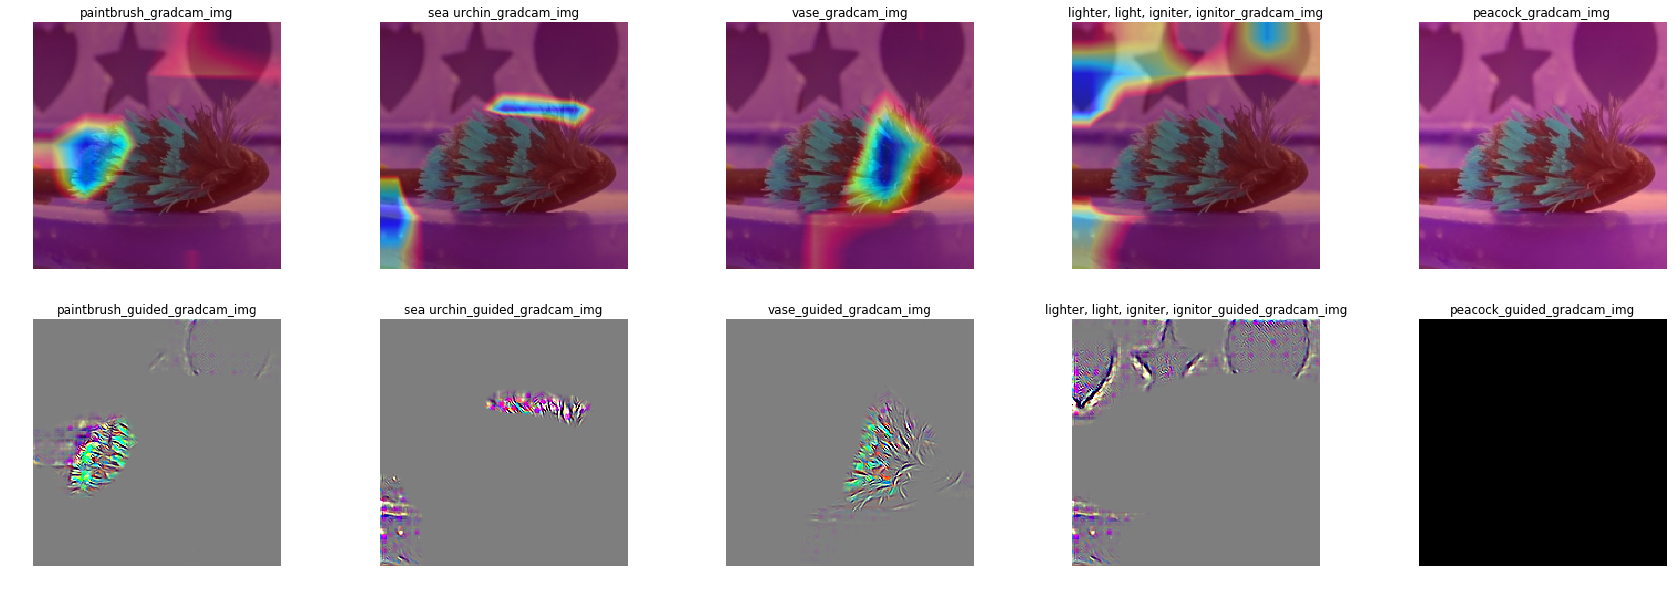

In [9]:
fig, axes1 = plt.subplots(2, 5, figsize=(30, 10))
for j in range(5):
    ret = insp.gradcam(sess, image, top5_result[j][1])
    axes1[0][j].set_axis_off()
    axes1[0][j].imshow(ret['gradcam_img'])
    axes1[0][j].set_title('{}_gradcam_img'.format(top5_result[j][0]))

    axes1[1][j].set_axis_off()
    axes1[1][j].imshow(ret['guided_gradcam_img'])
    axes1[1][j].set_title('{}_guided_gradcam_img'.format(top5_result[j][0]))
